In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_default = utils.load_default_model()
pretrained_vit_transforms = pretrained_vit_weights.transforms()

#We freeze all layers since we do not really want to train it again
for parameter in vit_default.parameters():
    parameter.requires_grad = False

loss_fn = nn.CrossEntropyLoss()

/home/p3rzival/TFG-Efficient-Vision-Transformer-Inference-on-Edge-Devices/utils.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(model_pa

In [3]:
train_dl, test_dl, val_dl, class_names = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=128)
vit_default

Files already downloaded and verified


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [4]:
transformer_1enc = utils.get_n_encoders(vit_default, 1)
transformer_1enc

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Dropout(p=0.0, inplace=False)
  (2): FlattenPermute(
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (3): EncoderBlock(
    (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (self_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): MLPBlock(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.0, inplace=False)
    )
  )
)

In [7]:
transformer_1enc.eval()
entropies = [0]*len(val_dl)
for idx, (x_batch, _) in enumerate(val_dl):
    res = transformer_1enc(x_batch)
    entropies[idx] = torch.log(torch.std(res))

In [25]:
mean_entropy = 0
n = 0
for i in entropies:
    mean_entropy += i
    n += 1
    
mean_entropy /= n

In [27]:
mean_entropy

tensor(-1.7731)

In [34]:
mean_entropies = [0]*12
for i in range(12):
    transformer = utils.get_n_encoders(vit_default, i+1).to(device)
    entropies = [0]*len(val_dl)
    for idx, (x_batch, _) in enumerate(val_dl):
        x_batch = x_batch.to(device)
        res = transformer(x_batch[0:50])
        entropies[idx] = torch.log(torch.std(res))
    print("First done")
    mean_entropy = 0
    n = 0
    for j in entropies:
        mean_entropy += j
        n+=1
    mean_entropy /= n
    mean_entropies[i] = mean_entropy

First done
First done
First done
First done
First done
First done
First done
First done
First done
First done
First done
First done


In [37]:
for idx, i in enumerate(mean_entropies):
    mean_entropies[idx] = mean_entropies[idx].cpu()

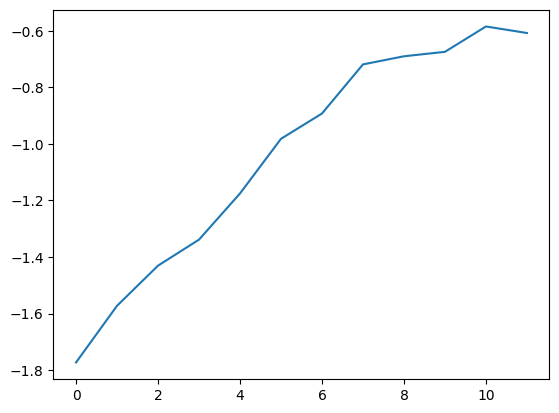

In [38]:
plt.plot(mean_entropies)